# Project info - unsupervised learning with KMeans

## Description

The Scitkit-learn module 'datasets' includes the 20 News Groups dataset, which is a text dataset including roughly 18,000 articles on 20 different topics.

The dataset includes labels for each article, but can also be analyzed in an unsupervised fashion.

# Import modules and tools

In [1]:
# standard libary and settings
import os
import sys
import importlib
import itertools
import csv
import ast
from timeit import default_timer as timer

global ITERATION
import time
from functools import reduce

rundate = time.strftime("%Y%m%d")

import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.base as base
import sklearn.cluster as cluster
import sklearn.datasets as datasets
import sklearn.decomposition as decomposition
import sklearn.discriminant_analysis as discriminant_analysis
import sklearn.ensemble as ensemble
import sklearn.feature_extraction as feature_extraction
import sklearn.feature_selection as feature_selection
import sklearn.gaussian_process as gaussian_process
import sklearn.linear_model as linear_model
import sklearn.kernel_ridge as kernel_ridge
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import sklearn.naive_bayes as naive_bayes
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
import sklearn.tree as tree
import sklearn.utils as utils

import eif as iso

from scipy import stats, special
import xgboost
import lightgbm
import catboost

from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from hyperopt.pyll.stochastic import sample

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

# Load, clean, inspect data

In [2]:
# Load data from scikit-learn

X = datasets.fetch_20newsgroups(
    subset="all",
    remove=("headers", "footers", "quotes"),
    categories=[
        "talk.politics.guns",
        "rec.sport.hockey",
        "comp.graphics",
        "sci.space",
        "rec.motorcycles",
    ],
)

# Dataset dimensions

print("Dataset dimensions: {0}".format(X.filenames.shape))

Dataset dimensions: (4865,)


In [3]:
np.unique(X.target, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([973, 996, 999, 987, 910], dtype=int64))

In [4]:
# Review article categories

Labels = X.target_names
Labels

['comp.graphics',
 'rec.motorcycles',
 'rec.sport.hockey',
 'sci.space',
 'talk.politics.guns']

In [5]:
# Sample from train data

X.data[0]

"Chemical weapons are not concidered a *very* effectiv weapon against\nmillitary forces. On civillians on the other hand....\n\nThat's one GOOD reason for banning it.\n\nYou need VAST amounts of chemicals to be affective, so the best reason\nto have/use it is price. (that's why it's called The Poor Mans A-bomb)\n\nAny thoughts on Bio-weapons ??\t\n\nIf this discusion is about civillians having chem-weapons;\nWhat should they use them on?? Rob a bank ??\n\n\n\n\tThis is not a .signature.\n\tIt's merely a computergenerated text to waste bandwith\n\tand to bring down the evil Internet.\n"

In [6]:
# Corresponding label

ix = X.target[0]
Labels[ix]

'talk.politics.guns'

## Convert text to vectors

In [7]:
# Build a bag of words model and use term frequency - inverse document frequency
# to understand how common or uncommon each word that appears in each document
# is relative to the rest of documents in the corpus

tfidf = feature_extraction.text.TfidfVectorizer(
    max_df=0.5,
    stop_words="english",
    ngram_range=(1, 1),
    lowercase=True,
    strip_accents="unicode",
)

tfidfPipe = pipeline.Pipeline([("vec", tfidf)])

vectorized = tfidfPipe.fit_transform(X.data)
vectorized.shape

(4865, 42619)

In [8]:
# Capture all unique words

vec = tfidfPipe.named_steps["vec"]
features = vec.get_feature_names()

__Document-specific word importances__

In [9]:
# Functions to determine word importance


def top_tfidf_feats(row, features, top_n=25):
    """
    Get top n tfidf values in row and return them 
    with their corresponding feature names.
    """
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ["feature", "tfidf"]
    return df


def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    """
    Top tfidf features in specific document (matrix row) 
    """
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

### Evaluate single article and word importances

In [10]:
# Sample from training data

X.data[1]

"\n\nIf I may offer a constructive criticism, perhaps you should decide if you\nlove vehicles or the use they are put to. I, myself, think the F-86 is\na beautiful aircraft, but rest assured, I wouldn't even think of flying\nit in combat today. Most of us want access to space and judge vehicles\non how they perform.\n\n\nNot to this degree.\n\n\nWhy?\n\n\nYour wrong. The DC approach is very tollerent of failure. It also has\nthe advantage of far greater reliability do to its reusable nature (Shuttle\nisn't reusable, it's salvagable).\n\n\nThe flip over happens at a very low speed, not supersonic. If the DC-X\nshows the flip over works, it will work unless the laws of physics change.\n\n\nThe final DC-1 will have fully intact abort throughout the entire flight\nenvelop. Upon re-entry for example, it can loose about 80% of available\nthrust and still land safely.\n\n\nEverything can suffer from catastrophic failure but that's not the same\nthing. Shuttle simply isn't a fault tolerent des

In [11]:
# Corresponding label for that training sample

ix = X.target[1]
Labels[ix]

'sci.space'

In [12]:
# Print words based on highest word importance values, within a single document

tfidfImp = top_feats_in_doc(vectorized, features, row_id=1, top_n=10)
tfidfImp

,feature,tfidf
0,dc,0.442381
1,shuttle,0.245136
2,envelop,0.184074
3,tollerent,0.184074
4,build,0.161937
5,abort,0.155066
6,flip,0.152601
7,intact,0.148402
8,reusable,0.143356
9,ssto,0.132968


__Corpus-wide word importances__

In [13]:
# The function is used for identifying word importances, across entire corpus


def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    """
    Return the top n features that on average are most important amongst 
    documents in rows indentified by indices in grp_ids.
    """
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [14]:
# Print words based on highest word importance values, within the entire corpus

top_mean_feats(vectorized, features, grp_ids=None, min_tfidf=0.3, top_n=10)

,feature,tfidf
0,game,0.002047
1,dog,0.001838
2,gm,0.001543
3,graphics,0.001445
4,bike,0.001400
5,feustel,0.001276
6,list,0.001187
7,espn,0.001155
8,tiff,0.001071
9,captain,0.001059


__Category-specific word importances__

In [15]:
# The function is used for identifying word importances, within each document category


def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    """
    Return a list of dfs, where each df holds top_n features and 
    their mean tfidf value calculated across documents with the 
    same class label.
    """
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y == label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [16]:
# Print words based on highest word importance values, within each class of documents
# In this case we're looking at atheism

dfs = top_feats_by_class(vectorized, X.target, features, min_tfidf=0.3, top_n=10)

In [20]:
# Review top words by importance for a specific class

topicIx = 1

print("Top features within category type {0} \n".format(Labels[topicIx]))
display(dfs[topicIx])

Top features within category type rec.motorcycles 



,feature,tfidf
0,dog,0.008978
1,bike,0.006840
2,helmet,0.003991
3,bmw,0.003601
4,list,0.003596
5,shaft,0.003569
6,tony,0.003293
7,honda,0.003292
8,lock,0.003257
9,drive,0.003177


# Cluster analysis

This section executes cluster analysis, an unsupervised learning technique, on the documents. It groups individual documents with other document that are determined by the algorithm to be similar. In this model, we will use KMeans to find K different clusters. In this case, we will use k = 20, because we know ther are 20 different categories. We can then compare the documents and their cluster labels to the actual labels to see how well KMeans performed its unsupervised learning task.

In [18]:
def grid_search(data, params):
    tfidf = feature_extraction.text.TfidfVectorizer(
        stop_words="english", lowercase=True, strip_accents="unicode"
    )

    lr_tfidf = pipeline.Pipeline(
        [
            ("vect", tfidf),
            (
                "clf",
                cluster.KMeans(
                    init="k-means++", n_clusters=5, random_state=0, verbose=0
                ),
            ),
        ]
    )
    gsTfIdf = model_selection.GridSearchCV(lr_tfidf, params, verbose=1, refit=True)

    gsTfIdf.fit(data)
    print()
    print("Best score: %0.3f" % gsTfIdf.best_score_)
    print("Best parameters set:")
    best_parameters = gsTfIdf.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return gsTfIdf

In [ ]:
param_grid = {
    "vect__ngram_range": [(1, 1)],
    "vect__use_idf": (True, False),
    "vect__max_df": np.linspace(0.25, 0.75, 4),
    "vect__max_features": np.arange(5000, 14001, 1000),
    "vect__norm": ["l1", "l2", None],
}

gsTfIdf = grid_search(X.data, param_grid)

In [21]:
# Replicate best model as chosen by GridSearchCV

tfidf = feature_extraction.text.TfidfVectorizer(
    max_df=0.25,
    max_features=14000,
    norm="l1",
    stop_words="english",
    ngram_range=(1, 1),
    lowercase=True,
    strip_accents="unicode",
    use_idf=False,
)

X_trainVec = tfidf.fit_transform(X.data)

In [26]:
distortions = []
for i in range(1, 7):
    km = cluster.KMeans(
        n_clusters=i, init="k-means++", n_init=3, max_iter=100, random_state=0
    )
    km.fit(X_trainVec)
    distortions.append(km.inertia_)

In [27]:
distortions

[291.27830287180535,
 290.451356440413,
 289.6718446544072,
 288.81056542901734,
 286.95281226036235,
 287.21441029252907]

Text(0, 0.5, 'Distortion')

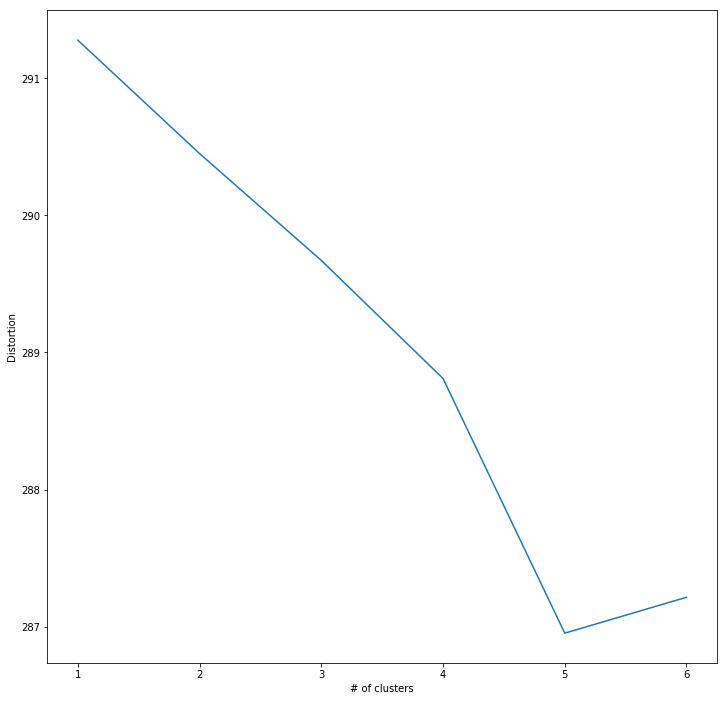

In [32]:
plt.figure(figsize=(12, 12))
plt.plot(np.arange(1, len(distortions) + 1), distortions)
plt.xlabel("# of clusters")
plt.ylabel("Distortion")

In [ ]:
#

kmlabels = grid_search.best_estimator_.fit_predict(X.data)

In [ ]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(X.target, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(X.target, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(X.target, km.labels_))